# Rozpoznawanie obiektów na obrazie RGB

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
execfile("util/generate.py")

Klasa `ImageObject` jest klasą reprezentującą wyodrębiony obiekt na obrazie. Zawiera w sobie `image`, który jest obrazem obiektu, i `bounding_box`, czyli współrzędne x i y oraz szerokość i wysokość prostokąta otaczającego obiekt, aby zachować informacje o jego położeniu na obrazie źródłowym.

In [7]:
class ImageObject:
    def __init__(self, image, bounding_box):
        self.image = image
        self.bounding_box = bounding_box  # Expected to be a tuple (x, y, width, height)

MIN_OBJECT_SIZE = 30

W pierwszym kroku obiekty są wyodrębniane z obrazu za pomocą funkcji `cv2.findContours`. Spośród wykrytych konturów usuwane są te, których rozmiar jest mniejszy od zdefiniowanego minimum.

In [8]:
def extract_objects(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define range for white color
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 255, 255])

    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(hsv, lower_white, upper_white)

    # Invert the mask to get non-white colors
    mask = cv2.bitwise_not(mask)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image, image, mask=mask)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    sizes = [size[2] * size[3] for size in [cv2.boundingRect(contour) for contour in contours] ]

    # Extract objects
    objects = []
    rects = []
    for contour in contours:
        rect = cv2.boundingRect(contour)
        size = rect[2] * rect[3]        
        x, y, w, h = cv2.boundingRect(contour)
        # Check if the object is bigger than the standard deviation
        if w > MIN_OBJECT_SIZE and h > MIN_OBJECT_SIZE:
            obj = image[y:y+h, x:x+w]
            objects.append(obj)
            rects.append(rect)

    return [ImageObject(obj, rect) for obj, rect in zip(objects, rects)]
    # return objects

### Obraz źródłowy

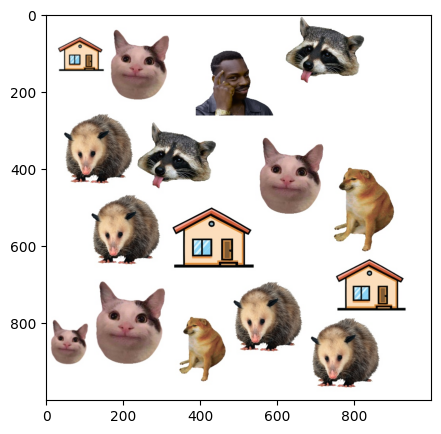

In [14]:
existing_files = os.listdir('generated_images')

image = cv2.imread(f'generated_images/{existing_files[1]}')
plt.figure(figsize=(5,5))
plt.imshow(
    cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
)

plt.show()

### Wyodrębniona kolekcja obiektów

ValueError: num must be an integer with 1 <= num <= 15, not 16

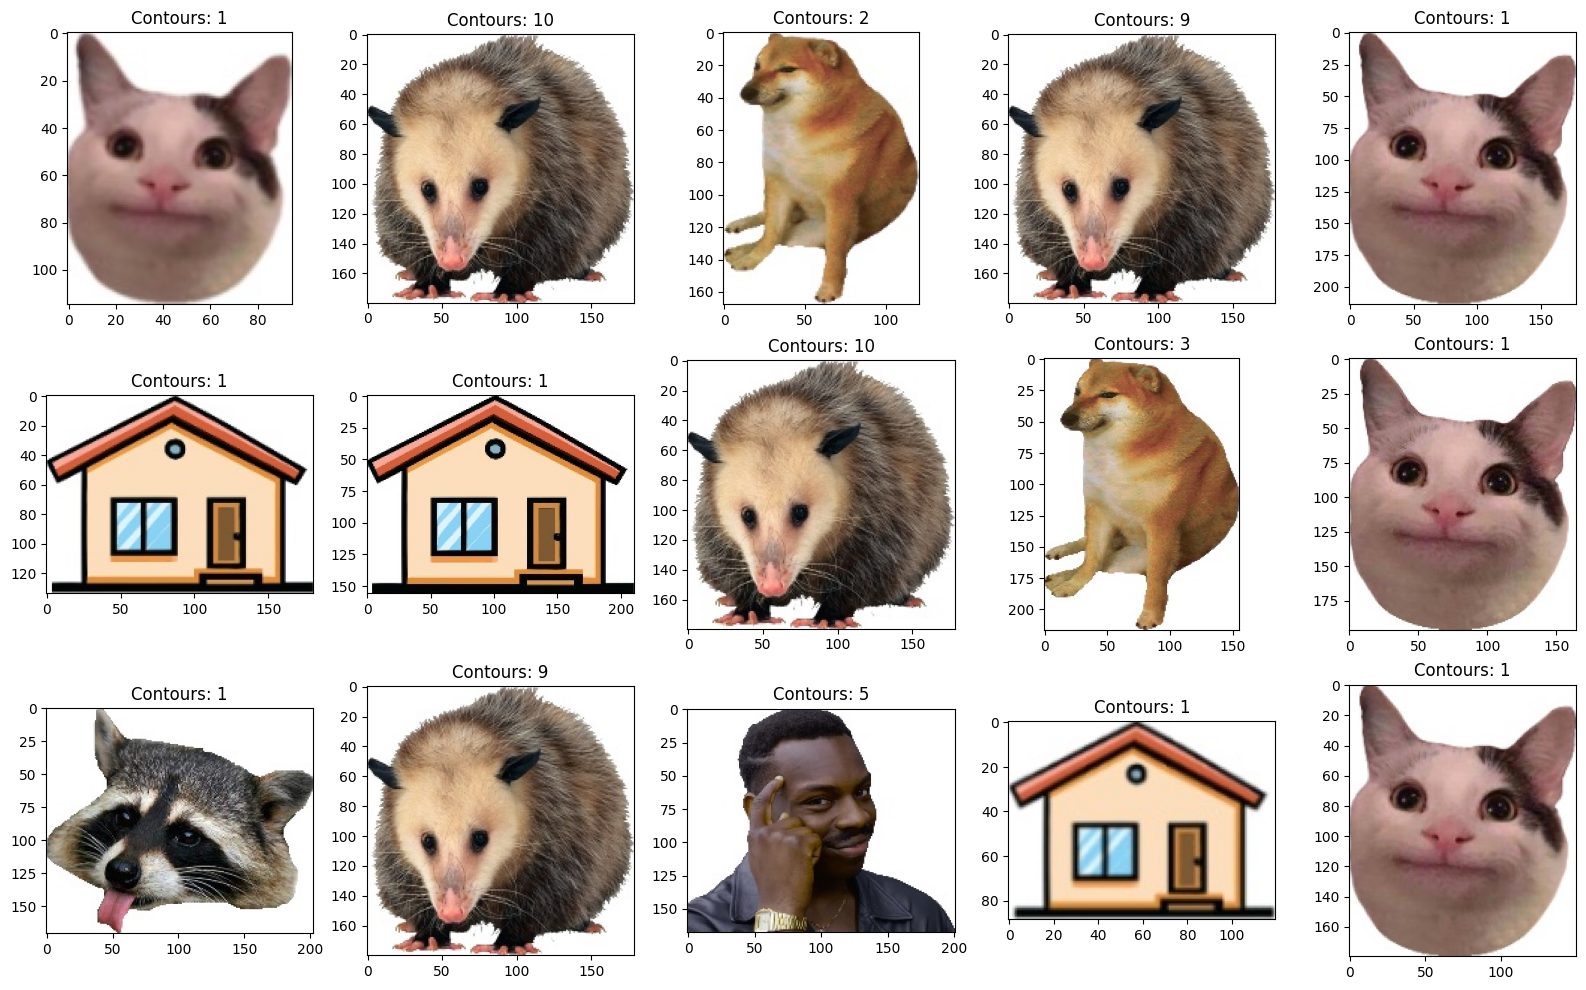

In [16]:
collection = extract_objects(image)
plot_collection([obj.image for obj in collection])

### Metody grupowania

Aby odnaleźć obrazy przedstawiające ten sam obiekt użyłem funkcji bibliotecznej `skimage.metrics.structural_similarity`. Aby zmniejszyć intensywność obliczeniową i ilość wymaganych porównań zapomocą powyższej funkcji, zdefiniowałem prostsze porównanie na podstawie stosunków krawędzi obrazu (aspect ratio). 

In [17]:
def compare_by_aspect_ratio(image1, image2):
    # Get the aspect ratios of the images
    aspect_ratio1 = image1.shape[1] / image1.shape[0]
    aspect_ratio2 = image2.shape[1] / image2.shape[0]

    if aspect_ratio1 < aspect_ratio2:
        aspect_ratio1, aspect_ratio2 = aspect_ratio2, aspect_ratio1

    # Calculate the difference between the aspect ratios
    cmp_ratio = aspect_ratio1 / aspect_ratio2

    # Return whether the difference is small enough
    return cmp_ratio < 1.05

In [18]:
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim

def compare_by_ssim(img1, img2):
    # Ensure the images are the same size
    if img1.shape != img2.shape:
        if img1.shape[0] > img2.shape[0]:
            img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]))
        else:
            img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # Compute SSIM between two images
    try:
        ssim_value = ssim(img1, img2, multichannel=True, channel_axis=-1)
    except ValueError:
        #print trace
        print("Error comparing images")
        print(img1.shape)
        print(img2.shape)
        return False


    # If SSIM is close to 1, they are very similar
    return ssim_value > 0.85

Poniższa funkcja przyjmuje listę obiektów oraz fukncję, która realizuje porównanie obrazów.

In [19]:
from typing import List
def group_objects(collection: List[ImageObject], compare_func):
    groups = []

    for obj in collection:
        # Try to find a group that this image belongs to
        for group in groups:
            if compare_func(obj.image, group[0].image):
                group.append(obj)
                break
        else:
            # If no suitable group was found, create a new group
            groups.append([obj])

    return groups

Wstępnie pogrupowana kolekcja zawiera w większości poprawne zbiory.

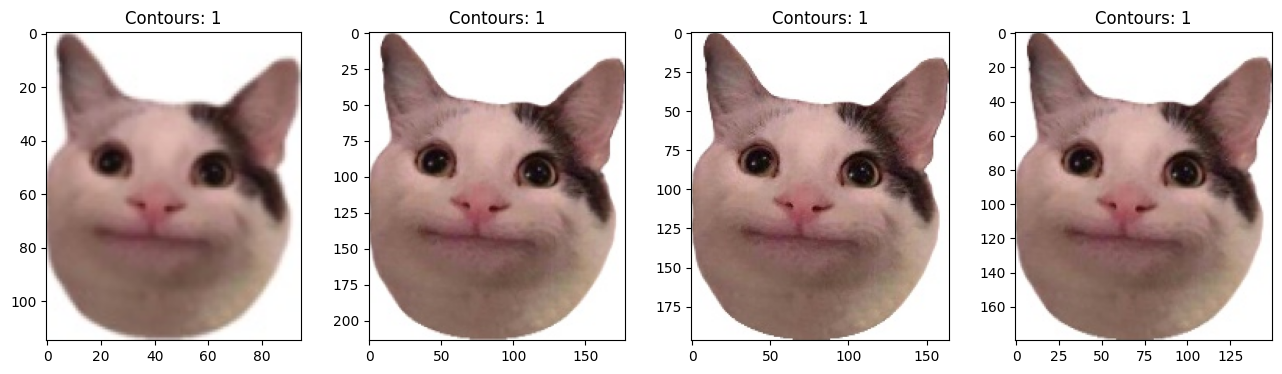

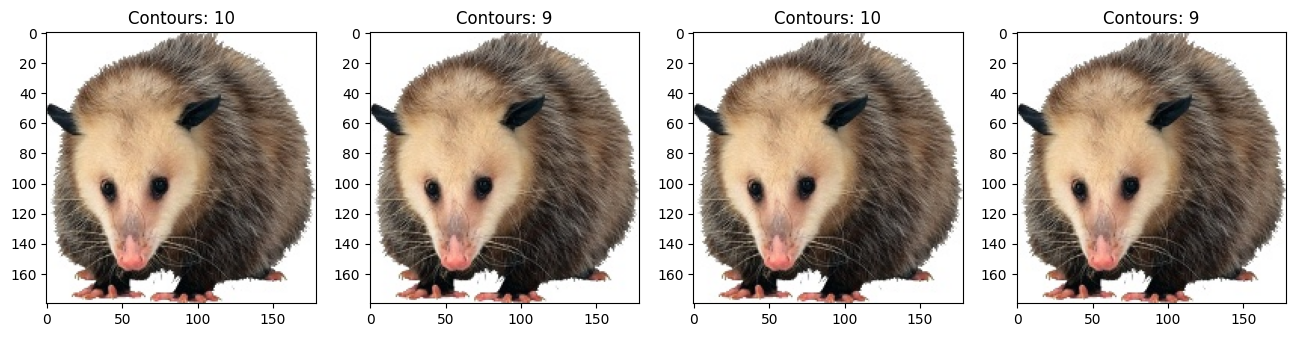

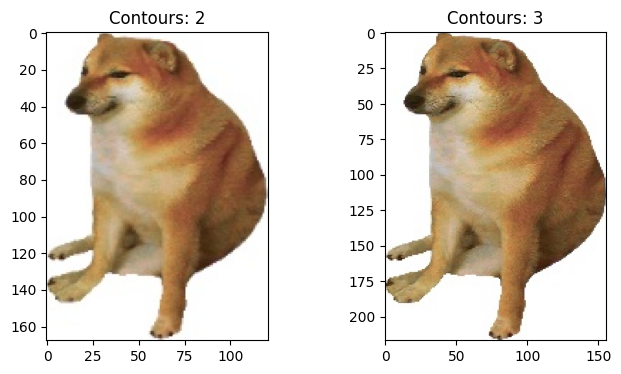

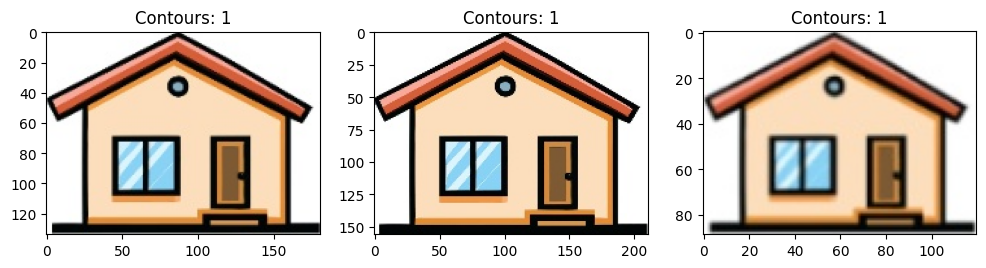

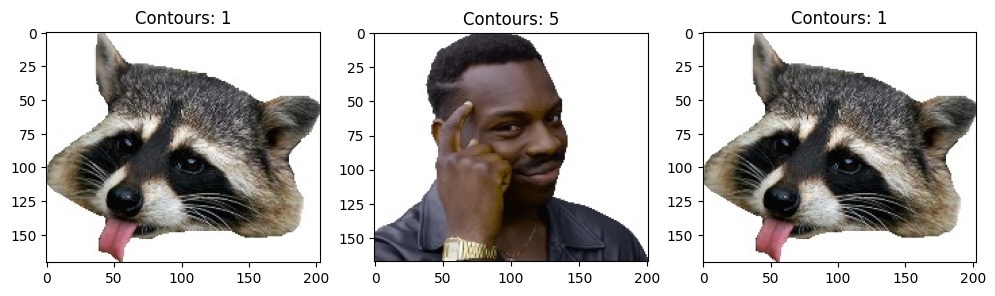

In [20]:
# collection = [ImageObject(img, bbox) for img, bbox in collection]
groups = group_objects(collection, compare_by_aspect_ratio)
# plot_collection([group.image for group in groups])
for group in groups:
    plot_collection([obj.image for obj in group])

Po drugim grupowaniu z użyciem podobieństwa strukturalnego, grupy zawierają tylko obiekty jendej klasy.

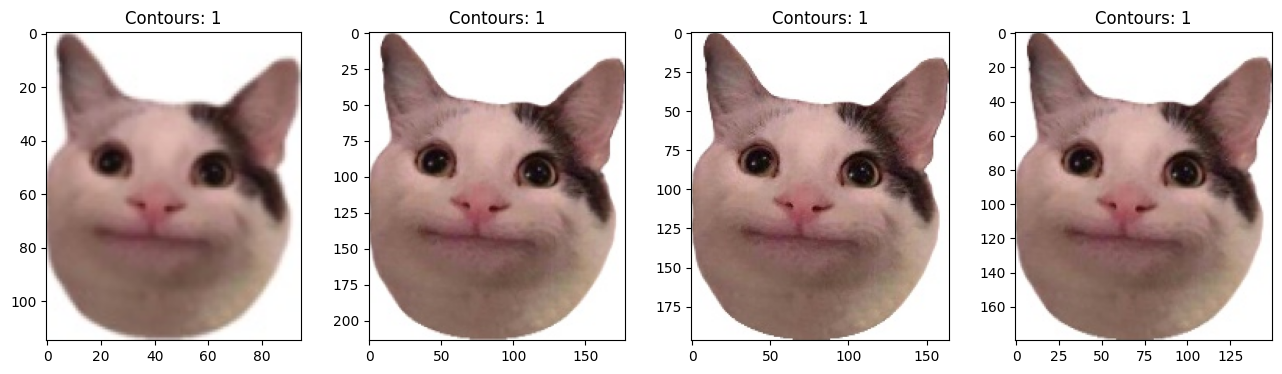

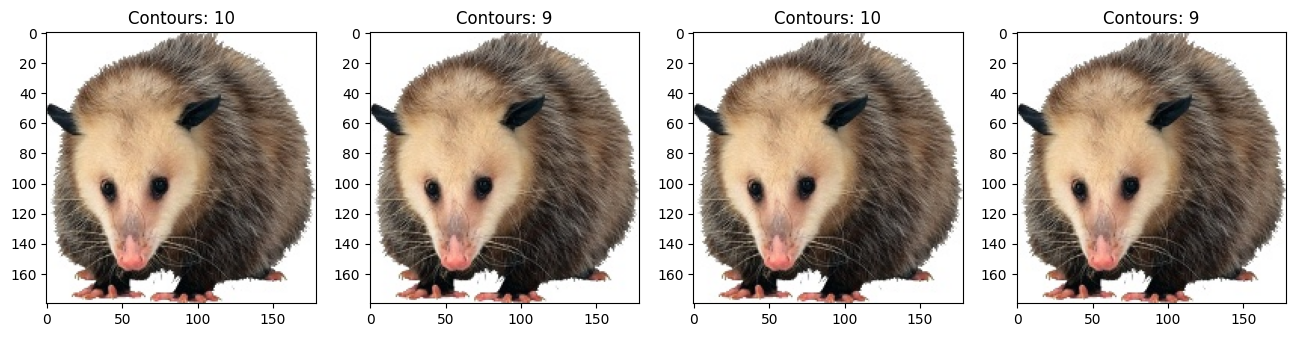

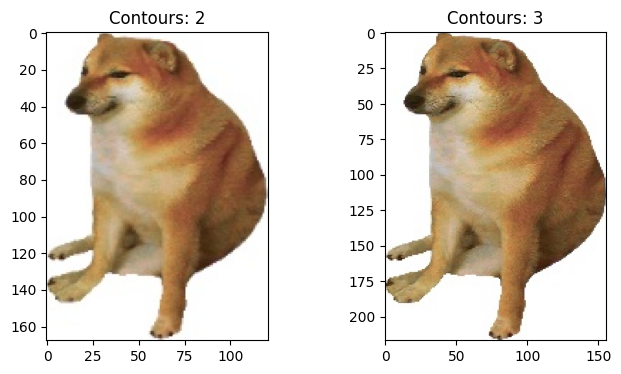

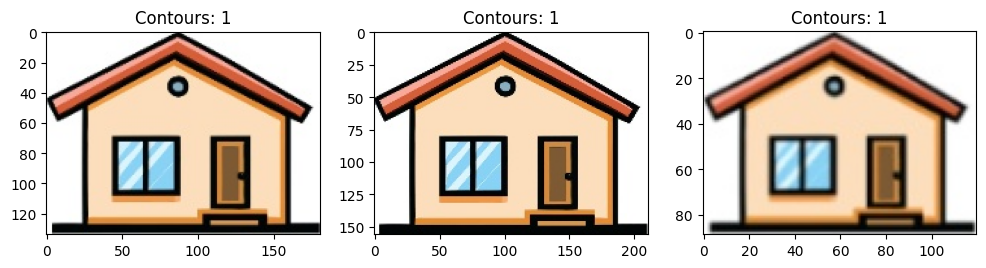

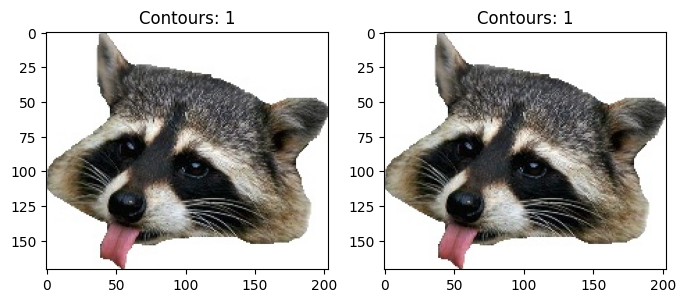

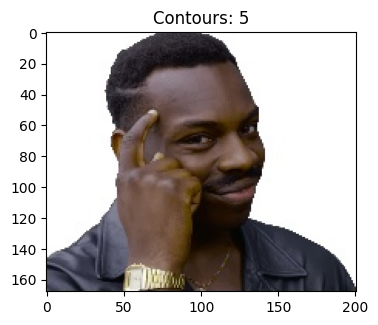

In [21]:
final_groups = []
for group in groups:
    final_groups.extend(group_objects(group, compare_by_ssim))

for group in final_groups:
    plot_collection([obj.image for obj in group])

Poniżej znajdują się funkcje wykonujące wszytskie powyższe kroki oraz zaznaczające te same obiekty na obrazie źródłowym.

In [22]:
import seaborn as sns
import matplotlib.patches as patches
# Set the color palette
sns.set_palette("husl")

def plot_with_groups(image, groups):
    colors = sns.color_palette()

    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    for i, group in enumerate(groups):
        color = colors[i % len(colors)]  # Cycle through colors if there are more groups than colors
        group.sort(key=lambda img_obj: img_obj.image.size, reverse=True)
        biggest_bbox_width = group[0].bounding_box[2]

        for image_object in group:
            x, y, w, h = image_object.bounding_box
            size_ratio = w / biggest_bbox_width

            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)

            fontsize = 6
            ax.text(x + 5, y + fontsize * 2, str(round(size_ratio, 2)), color='white', weight='bold', backgroundcolor=color, fontsize=fontsize)

    plt.show()

In [26]:
def find_matching_objects(image):
    # Extract objects from the image
    objects =  extract_objects(image)
    # Group the objects by aspect ratio
    groups = group_objects(objects, compare_by_aspect_ratio)

    # Group the objects by SSIM
    final_groups = []
    for group in groups:
        final_groups.extend(group_objects(group, compare_by_ssim))

    # Remove groups with only one object
    for group in final_groups.copy():
        if len(group) < 2:
            final_groups.remove(group)

    return final_groups

Poniższy kod wykonuje grupowanie na wszystkich obrazach źródłowych w katalogu, w tym przypadku 3.

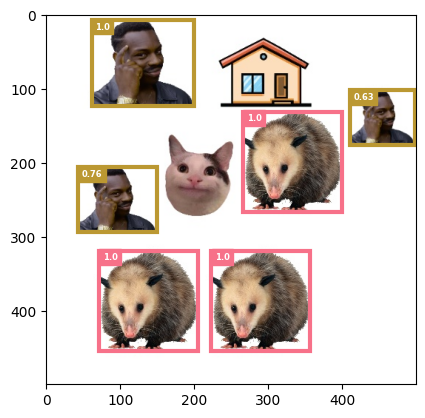

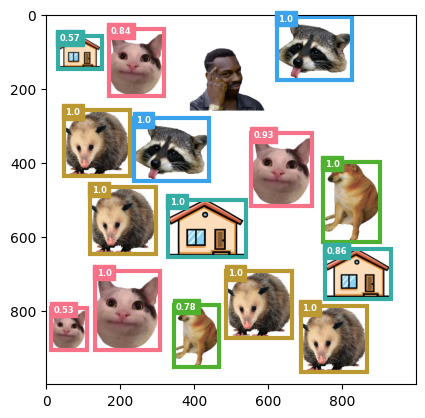

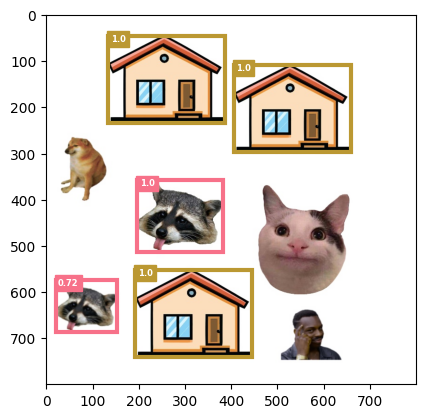

In [27]:
existing_files = os.listdir('generated_images')

for file in existing_files:
    # Read the image
    image = cv2.imread(f'generated_images/{file}')
    
    # Process the image using find_matching_objects function
    plot_with_groups(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 
        find_matching_objects(image)
    )